# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
from __future__ import print_function, division

import torch
import bcolz as bz
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = '/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [64]:
# Hyperparameters
batch_size = 64
data_dir = '/flowers'
num_classes = 102
num_hidden=4096
num_features = 512
learning_rate = 0.01
num_epochs = 25
best_accuracy=0.0
resume_weights_v="data/vgg_checkpoint.pth.tar"
resume_weights_a="data/alex_checkpoint.pth.tar"
model_weights_path_vgg='data/vgg_checkpoint.pth.tar'
model_weights_path_alex='data/alex_checkpoint.pth.tar'

In [106]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = 

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(30),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
}
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val','test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx
use_gpu = torch.cuda.is_available()

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
#We are going to use two pretained models (alexnet and vgg16) and will be finetuning the final classifier layers
alexnet = torchvision.models.alexnet(pretrained=True)
vgg16 = torchvision.models.vgg16(pretrained=True)

models = {'alexnet': alexnet, 'vgg16': vgg16}


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:04<00:00, 57851850.63it/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:30<00:00, 18387012.09it/s]


## Train the model

We will now be defining the train and testing function and some more function that will be using in the code

In [7]:
def train(model,size,train_b=None,train_labels=None,val_b=None,val_lables=None,epochs=1,optimizer=None,criterion=None,train=True,shuffle=True,filename=None):
    best_accuracy=0.0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs -1))
        
        for phase in ['train', 'val']:
            total = 0
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()
                batches = data_gen(conv_feat=train_b,labels=train_labels,shuffle=shuffle)
            
                for inputs,classes in batches:
                    if use_gpu:
                        inputs , classes = Variable(torch.from_numpy(inputs).cuda(0)),Variable(torch.from_numpy(classes).cuda(0))
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                
                    inputs = inputs.view(inputs.size(0), -1)
                    outputs = model(inputs)
                    loss = criterion(outputs,classes)           
                    if train:
                        if optimizer is None:
                            raise ValueError('Pass optimizer for train mode')
                    optimizer = optimizer
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    _,preds = torch.max(outputs.data,1)
                    # statistics
                    running_loss += loss.data[0]
                    running_corrects += torch.sum(preds == classes.data)
            else:
                model.eval()
                batches = data_gen(conv_feat=val_b,labels=val_lables,shuffle=shuffle)
                for inputs,classes in batches:
                    if use_gpu:
                        inputs , classes = Variable(torch.from_numpy(inputs).cuda(0)),Variable(torch.from_numpy(classes).cuda(0))
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                
                    inputs = inputs.view(inputs.size(0), -1)
                    outputs = model(inputs)
                    loss = criterion(outputs,classes)           
                    
                    _,preds = torch.max(outputs.data,1)
                    # statistics
                    running_loss += loss.data[0]
                    running_corrects += torch.sum(preds == classes.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_accuracy:
                is_best = epoch_acc > best_accuracy
                best_accuracy = epoch_acc
                model.class_to_idx=class_to_idx
                state = {
                        'epoch': epoch+1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'best_accuracy': best_accuracy,
                        'class_to_idx':model.class_to_idx
                        }
                save_checkpoint(state, is_best,filename)
                #save_checkpoint({
                    #'epoch': epoch + 1,
                    #'state_dict': model.state_dict(),
                    #'best_accuracy': best_accuracy,
                    #'optimizer': optimizer.state_dict()
    #}, is_best,filename)
    print()

In [8]:
def test(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            if use_gpu:
                inputs , classes = Variable(torch.from_numpy(inputs).cuda(0)),Variable(torch.from_numpy(classes).cuda(0))
            else:
                inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [9]:
#batch generater for batches in train/test model code
def data_gen(conv_feat,labels,batch_size=batch_size,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])
#will save the checkpoint while training
def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

def save_array(filename, arr):
    c=bz.carray(arr, rootdir=filename, mode='w')
    c.flush()
def load_array(filename):
    return bz.open(filename)[:]

In [10]:
# Load checkpoint function
def loadcheckpoint(model):
    if model=="vgg16":
        resume_weights = model_weights_path_vgg
        model=vgg()

    else:
        resume_weights = model_weights_path_alex
        model=alex()
    if use_gpu:
        model= model.cuda(0)
    
    if os.path.isfile(resume_weights):
        print("=> loading checkpoint '{}' ...".format(resume_weights))
        if use_gpu:
            checkpoint = torch.load(resume_weights)
        else:
            # Load GPU model on CPU
            checkpoint = torch.load(resume_weights,
                                    map_location=lambda storage,
                                    loc: storage)
        start_epoch = checkpoint['epoch']
        best_accuracy = checkpoint['best_accuracy']
        model.classifier.load_state_dict(checkpoint['state_dict'])
        model.class_to_idx=checkpoint['class_to_idx']
        
        print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights,checkpoint['epoch']))
        return model

In [11]:
#Finetuning the models
class FineTuneModel(nn.Module):
    def __init__(self, original_model, arch, num_classes,num_features):
        super(FineTuneModel, self).__init__()

        if arch.startswith('alexnet') :
            self.features = original_model.features
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 6 * 6, num_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(num_hidden, num_hidden),
                nn.ReLU(inplace=True),
                nn.Linear(num_hidden, num_classes),
            )
            self.modelName = 'alexnet'
    
        elif arch.startswith('vgg16'):
            self.features = original_model.features
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(25088, num_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(num_hidden, num_hidden),
                nn.ReLU(inplace=True),
                nn.Linear(num_hidden, num_classes),
            )
            self.modelName = 'vgg16'
        else :
            raise("Finetuning not supported on this architecture yet")

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False


    def forward(self, x):
        f = self.features(x)
        if self.modelName == 'alexnet' :
            f = f.view(f.size(0), 256 * 6 * 6)
        elif self.modelName == 'vgg16':
            f = f.view(f.size(0), -1)
        elif self.modelName == 'resnet' :
            f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

In [81]:
#Loading the vgg16 model and freezing the parameters ofr feature network
def vgg():
    model_v= torchvision.models.vgg16(pretrained=True)
    num_ftrs = model_v.classifier[6].in_features
    features = list(model_v.classifier.children())[:-1]
    features.extend([nn.Linear(num_ftrs, num_classes)])
    model_v.classifier = nn.Sequential(*features)
    model_v = FineTuneModel(model_v, 'vgg16', num_classes,num_hidden)
    #print(model)
    for param in model_v.parameters():
        param.requires_grad = False
    model_v.classifier[6].out_features = num_classes
    for param in model_v.classifier[6].parameters():
        param.requires_grad = True
    if use_gpu:
        model_v = model_v.cuda(0)
    model_v.class_to_idx = class_to_idx
    return model_v

model_v=vgg()


In [82]:
#code that will help with feature extraction
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        inputs , labels = Variable(inputs.cuda(0)),Variable(labels.cuda(0))
        x = model.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [83]:
#extract features
conv_feat_train,labels_train = preconvfeat(dataloaders['train'],model_v)
conv_feat_val,labels_val = preconvfeat(dataloaders['val'],model_v)

In [84]:
save_array('data/conv_feat_trainvgg.bc', conv_feat_train)
save_array('data/labels_trainvgg.bc', labels_train)
save_array('data/conv_feat_valvgg.bc', conv_feat_val)
save_array('data/labels_valvgg.bc', labels_val)


In [85]:
#training the final layer and defining loss and optimizer
for param in model_v.classifier.parameters():
    param.requires_grad = True
if use_gpu:
    model_v = model_v.cuda(0)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_v.classifier.parameters(),lr = lr)
#setting the dropout and training the network



In [86]:
model_v.classifier[5].p = 0.5
model_v.classifier[2].p = 0.5
if use_gpu:
    model_v= model_v.cuda(0)

In [87]:
%%time
(train(model=model_v.classifier,size=dataset_sizes,train_b=conv_feat_train,train_labels=labels_train,val_b=conv_feat_val,val_lables=labels_val,
            epochs=num_epochs,optimizer=optimizer,criterion=criterion,train=True,shuffle=True,filename=resume_weights_v))

Epoch 0/39
train Loss: 0.0701 Acc: 0.0524
val Loss: 0.0666 Acc: 0.1381
=> Saving a new best
Epoch 1/39
train Loss: 0.0646 Acc: 0.1279
val Loss: 0.0559 Acc: 0.2738
=> Saving a new best
Epoch 2/39
train Loss: 0.0543 Acc: 0.2486
val Loss: 0.0431 Acc: 0.3411
=> Saving a new best
Epoch 3/39
train Loss: 0.0422 Acc: 0.3826
val Loss: 0.0347 Acc: 0.4242
=> Saving a new best
Epoch 4/39
train Loss: 0.0326 Acc: 0.5040
val Loss: 0.0298 Acc: 0.4768
=> Saving a new best
Epoch 5/39
train Loss: 0.0261 Acc: 0.5904
val Loss: 0.0214 Acc: 0.6076
=> Saving a new best
Epoch 6/39
train Loss: 0.0216 Acc: 0.6624
val Loss: 0.0232 Acc: 0.6015
Epoch 7/39
train Loss: 0.0179 Acc: 0.7161
val Loss: 0.0200 Acc: 0.6516
=> Saving a new best
Epoch 8/39
train Loss: 0.0150 Acc: 0.7706
val Loss: 0.0172 Acc: 0.6932
=> Saving a new best
Epoch 9/39
train Loss: 0.0126 Acc: 0.8100
val Loss: 0.0148 Acc: 0.7225
=> Saving a new best
Epoch 10/39
train Loss: 0.0107 Acc: 0.8404
val Loss: 0.0130 Acc: 0.7567
=> Saving a new best
Epoch 11

In [88]:
#Replicating the work done on vgg for alexnet
def alex():
    model_a = torchvision.models.alexnet(pretrained=True)
    num_ftrs = model_a.classifier[6].in_features
    features = list(model_a.classifier.children())[:-1]
    features.extend([nn.Linear(num_ftrs, num_classes)])
    model_a.classifier = nn.Sequential(*features)
    model_a = FineTuneModel(model_a, "alexnet", num_classes,num_hidden)
    #print(model)
    for param in model_a.parameters():
        param.requires_grad = False
    model_a.classifier[6].out_features = num_classes
    for param in model_a.classifier[6].parameters():
        param.requires_grad = True
    if use_gpu:
        model_a = model_a.cuda(0)
    model_a.class_to_idx = class_to_idx
    return model_a
model_a=alex()

In [89]:
%%time
conv_feat_train,labels_train = preconvfeat(dataloaders['train'],model_a)

CPU times: user 2.5 s, sys: 2.19 s, total: 4.69 s
Wall time: 1min 28s


In [90]:
%%time
conv_feat_val,labels_val = preconvfeat(dataloaders['val'],model_a)

CPU times: user 276 ms, sys: 344 ms, total: 620 ms
Wall time: 12.3 s


In [91]:
#save the featues for later use
save_array('data/conv_feat_trainalex.bc', conv_feat_train)
save_array('data/labels_trainalex.bc', labels_train)
save_array('data/conv_feat_valalex.bc', conv_feat_val)
save_array('data/labels_valalex.bc', labels_val)


In [92]:
for param in model_a.classifier.parameters():
    param.requires_grad = True
if use_gpu:
    model_a = model_a.cuda(0)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_a.classifier.parameters(),lr = lr)
model_a.classifier[5].p = 0.3
model_a.classifier[2].p = 0.3
if use_gpu:
    model_a= model_a.cuda(0)

In [93]:
%%time
(train(model=model_a.classifier,size=dataset_sizes,train_b=conv_feat_train,train_labels=labels_train,val_b=conv_feat_val,val_lables=labels_val,
            epochs=num_epochs,optimizer=optimizer,criterion=criterion,train=True,shuffle=True,filename=resume_weights_a))

Epoch 0/39
train Loss: 0.0673 Acc: 0.0846
val Loss: 0.0555 Acc: 0.2592
=> Saving a new best
Epoch 1/39
train Loss: 0.0534 Acc: 0.2289
val Loss: 0.0400 Acc: 0.3362
=> Saving a new best
Epoch 2/39
train Loss: 0.0407 Acc: 0.3674
val Loss: 0.0316 Acc: 0.4389
=> Saving a new best
Epoch 3/39
train Loss: 0.0327 Acc: 0.4710
val Loss: 0.0249 Acc: 0.5721
=> Saving a new best
Epoch 4/39
train Loss: 0.0271 Acc: 0.5539
val Loss: 0.0224 Acc: 0.6271
=> Saving a new best
Epoch 5/39
train Loss: 0.0228 Acc: 0.6129
val Loss: 0.0193 Acc: 0.6589
=> Saving a new best
Epoch 6/39
train Loss: 0.0199 Acc: 0.6653
val Loss: 0.0223 Acc: 0.6271
Epoch 7/39
train Loss: 0.0176 Acc: 0.6993
val Loss: 0.0170 Acc: 0.6993
=> Saving a new best
Epoch 8/39
train Loss: 0.0153 Acc: 0.7402
val Loss: 0.0149 Acc: 0.7457
=> Saving a new best
Epoch 9/39
train Loss: 0.0139 Acc: 0.7642
val Loss: 0.0186 Acc: 0.6895
Epoch 10/39
train Loss: 0.0124 Acc: 0.7831
val Loss: 0.0134 Acc: 0.7592
=> Saving a new best
Epoch 11/39
train Loss: 0.010

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [94]:
# TODO: Do validation on the test set
# VGG
conv_feat_train = load_array('data/conv_feat_trainvgg.bc')
labels_train = load_array('data/labels_trainvgg.bc')
conv_feat_val = load_array('data/conv_feat_valvgg.bc')
labels_val = load_array('data/labels_valvgg.bc')
test(conv_feat=conv_feat_val,labels=labels_val,model=model_v.classifier
            ,size=dataset_sizes['test'],train=False,shuffle=True)


Loss: 0.0097 Acc: 0.8462


In [95]:
# Alex
#load the features
conv_feat_train = load_array('data/conv_feat_trainalex.bc')
labels_train = load_array('data/labels_trainalex.bc')
conv_feat_val = load_array('data/conv_feat_valalex.bc')
labels_val = load_array('data/labels_valalex.bc')
test(conv_feat=conv_feat_val,labels=labels_val,model=model_a.classifier
            ,size=dataset_sizes['test'],train=False,shuffle=True)

Loss: 0.0113 Acc: 0.8352


Good loss considering we only trained it for 40 epochs, there is overfitting.Further steps would be to device strategy to reduce the overfitting

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [96]:
# TODO: Save the checkpoint 
# Saving The Model:
#def savemodel(use_gpu,model,name):
    #if use_gpu:
        #model = model.cuda(0)
    
    #if name == 'vgg16':
        #model_weights_path = model_weights_path_vgg
    #else:
        #model_weights_path = model_weights_path_alex
    
    #model.class_to_idx = class_to_idx
    #torch.save(model, model_weights_path)
#This function will store the checkpoint while training and will save the best model.The same function is defined above.The class_to_idx is stored within the training itself
def save_checkpoint(state, is_best, filename='/data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [97]:
#Demostration for loading a trained model
model_p=loadcheckpoint('vgg16')

=> loading checkpoint 'data/vgg_checkpoint.pth.tar' ...
=> loaded checkpoint 'data/vgg_checkpoint.pth.tar' (trained for 35 epochs)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [98]:
    # TODO: Write a function that loads a checkpoint and rebuilds the model
    def loadcheckpoint(model):
        if model=="vgg16":
            resume_weights = model_weights_path_vgg
            model=vgg()

        else:
            resume_weights = model_weights_path_alex
            model=alex()
        if use_gpu:
            model= model.cuda(0)

        if os.path.isfile(resume_weights):
            print("=> loading checkpoint '{}' ...".format(resume_weights))
            if use_gpu:
                checkpoint = torch.load(resume_weights)
            else:
                # Load GPU model on CPU
                checkpoint = torch.load(resume_weights,
                                        map_location=lambda storage,
                                        loc: storage)
            start_epoch = checkpoint['epoch']
            best_accuracy = checkpoint['best_accuracy']
            model.classifier.load_state_dict(checkpoint['state_dict'])
            model.class_to_idx=(checkpoint['class_to_idx'])
            print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights,checkpoint['epoch']))
            return model

In [112]:
def loadclasses(model):
    (class_to_idx)=model.class_to_idx
    import json
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)

    for k,v in cat_to_name.items():
        #print(k)
        i=int(k)-1
        class_to_idx[i] = class_to_idx[k]
        del class_to_idx[k]
        class_to_idx[i]=v

    return class_to_idx


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [113]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    img_tensor = preprocess(Image.open(image))
    
    return img_tensor
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [114]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    if title is not None:
        plt.title(title)
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [115]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model_p=loadcheckpoint(model)
    #model_p=pretrained_dict
    class_to_idx=loadclasses(model_p)
    if use_gpu:
        data = Variable((process_image(image_path)).unsqueeze_(0), volatile=True).cuda(0)
    else:
         data = Variable((process_image(image_path)).unsqueeze_(0), volatile=True)        

    model_p = model_p.eval()
    # apply data to model
    output = model_p(data)

    o=(output.topk(5))
    flowerlist=[]
    problist=[]
    for i in range(5):
        c=(o[1][0][i])
        cin=(c.data.cpu().numpy()[0])
       
        flowerlist.append(class_to_idx[cin])
        c=(o[0][0][i])
        cin=(c.data.cpu().numpy()[0])
        
        problist.append(cin)

    return (flowerlist,problist)
  
    
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [116]:
def sanitycheck(img,flowerlist,problist):
    
    img_path=img
    imshow(process_image(img_path),title=flowerlist[0])

    # Example data
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(flowerlist))
    error = np.random.rand(len(flowerlist))
    ax.barh(y_pos, problist, xerr=error, align='center',
            color='blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(flowerlist)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Probalities')
    ax.set_title('Top 5 Prediction')

    plt.show()

=> loading checkpoint 'data/vgg_checkpoint.pth.tar' ...
=> loaded checkpoint 'data/vgg_checkpoint.pth.tar' (trained for 35 epochs)
['pink primrose', 'lotus lotus', 'desert-rose', 'cyclamen', 'king protea']
[15.032711, 9.391831, 9.3867035, 8.804453, 7.999736]


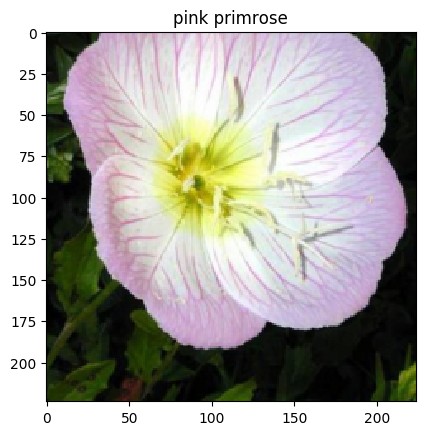

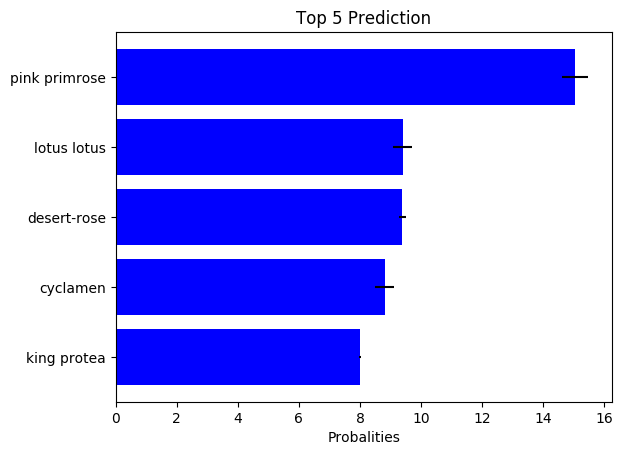

In [117]:
img_path="/flowers/test/1/image_06743.jpg"
flowerlist,problist=predict(img_path,'vgg16',5)
print(flowerlist)
print(problist)
sanitycheck(img_path,flowerlist,problist)


=> loading checkpoint 'data/alex_checkpoint.pth.tar' ...
=> loaded checkpoint 'data/alex_checkpoint.pth.tar' (trained for 33 epochs)
['pink primrose', 'cyclamen', 'carnation', 'yellow iris', 'common dandelion']
[25.16962, 19.810217, 15.632894, 13.184729, 12.843945]


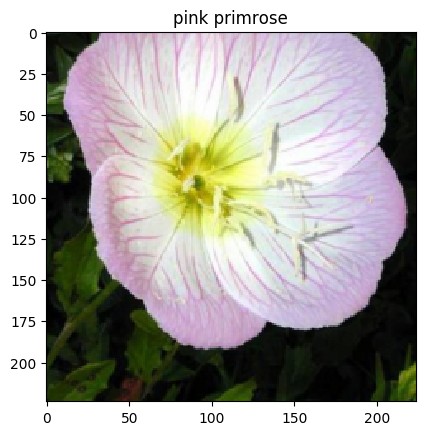

In [118]:
img_path="/flowers/test/1/image_06743.jpg"
flowerlist,problist=predict(img_path,'alexnet',5)
print(flowerlist)
print(problist)
sanitycheck(img_path,flowerlist,problist)